In [1]:
## 推論性国確率を0.1, 0.5, 0.9

ANOVA Results for TopSim_CV0: F-statistic=1.273, p-value=2.797e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for TopSim_CV1: F-statistic=1.786, p-value=1.307e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Normalized_TopSim_CV0: F-statistic=0.853, p-value=4.921e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Normalized_TopSim_CV1: F-statistic=1.061, p-value=3.754e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Ibuki_1_TopSim_CV0: F-statistic=0.960, p-value=4.294e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Ibuki_1_TopSim_CV1: F-statistic=1.360, p-value=2.471e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Ibuki_2_TopSim: F-statistic=1.860, p-value=1.167e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Ibuki_3_TopSim: F-statistic=1.785, p-value=1.308e-01
帰無仮説は否定されない（有意水準: α=0.05）

ANOVA Results for Ibuki_4_TopSim_Variances: F-statistic=2.889, p-value=2.218e-02
帰無仮説は否定される（有意水準: α=0.05）

ANOVA Results for Ibuki_4_TopSim_Averages: F-statistic=17.122, p-value=5.335e-13
帰無仮説は否定される（有意水

<Figure size 800x600 with 0 Axes>

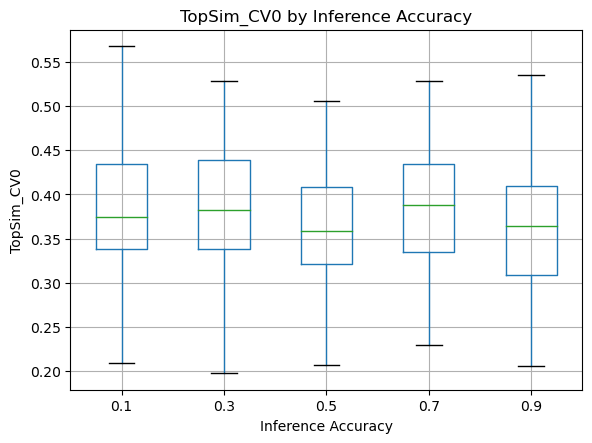

<Figure size 800x600 with 0 Axes>

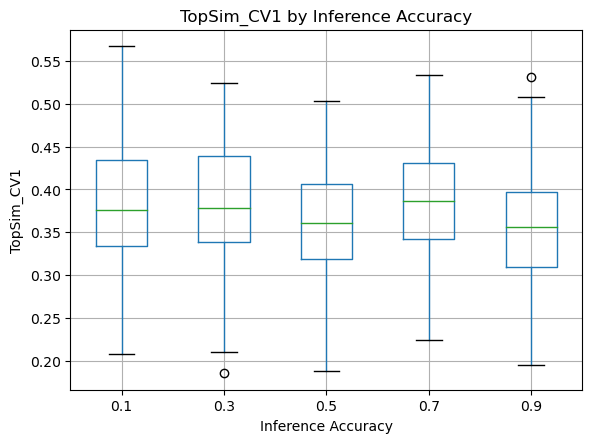

<Figure size 800x600 with 0 Axes>

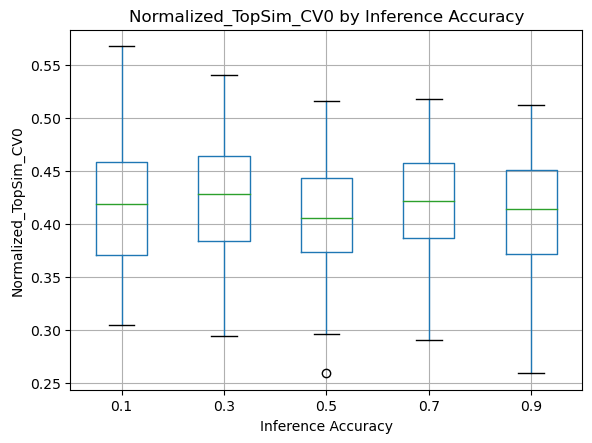

<Figure size 800x600 with 0 Axes>

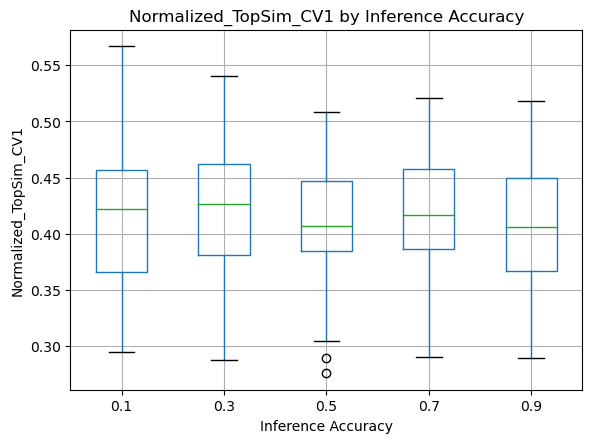

<Figure size 800x600 with 0 Axes>

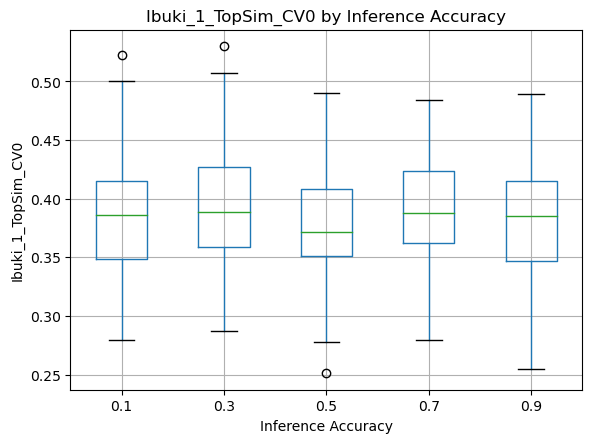

<Figure size 800x600 with 0 Axes>

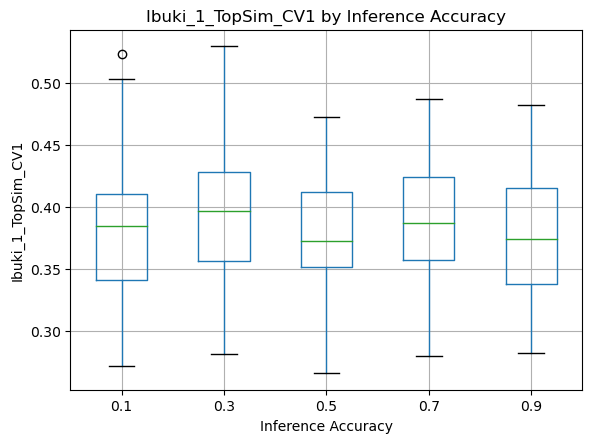

<Figure size 800x600 with 0 Axes>

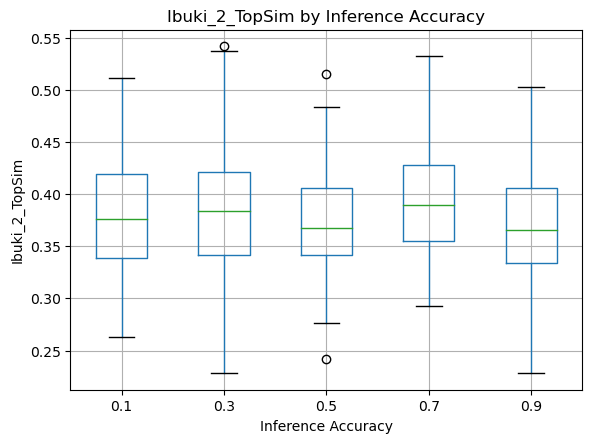

<Figure size 800x600 with 0 Axes>

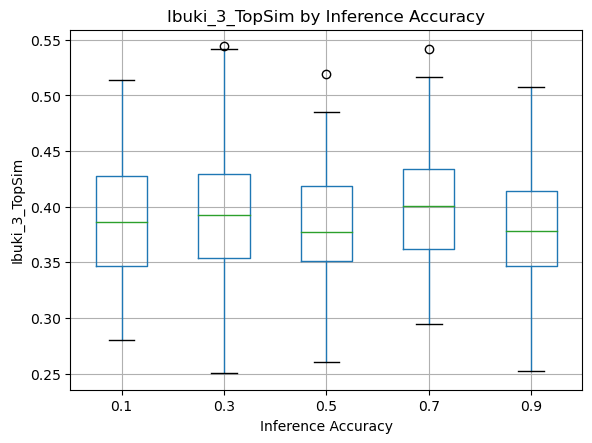

<Figure size 800x600 with 0 Axes>

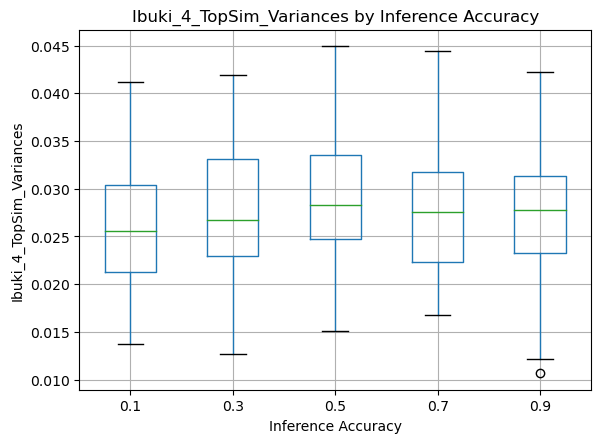

<Figure size 800x600 with 0 Axes>

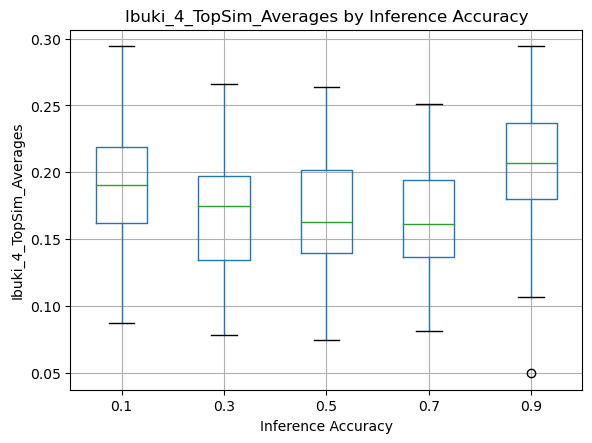

<Figure size 800x600 with 0 Axes>

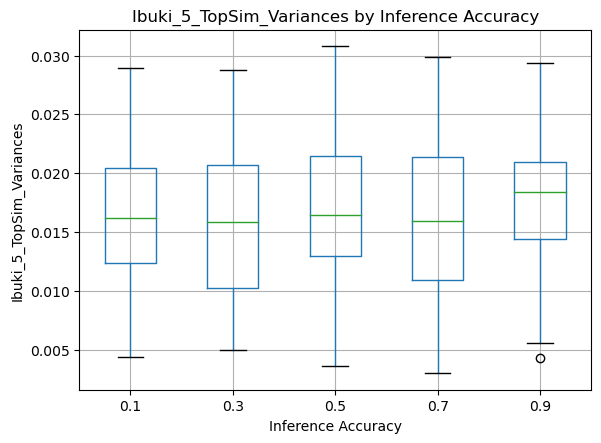

<Figure size 800x600 with 0 Axes>

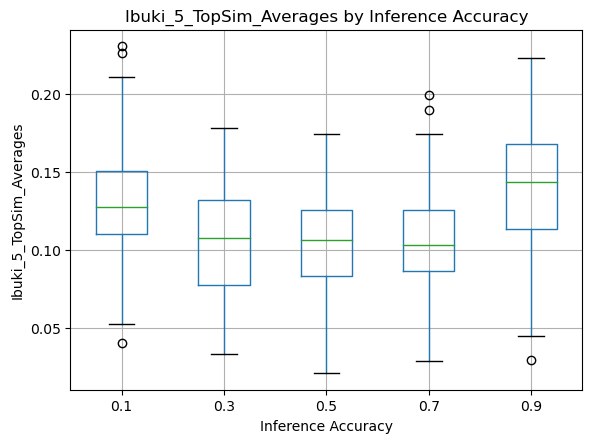

In [2]:
import os
import json
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

def load_data_for_analysis(base_folder, target_folders):
    """
    特定のフォルダに保存されたシミュレーションデータを取得。
    """
    data = []
    
    for folder in target_folders:
        folder_path = os.path.join(base_folder, folder)
        
        if os.path.isdir(folder_path):
            for seed_folder in os.listdir(folder_path):
                seed_path = os.path.join(folder_path, seed_folder)
                json_file = os.path.join(seed_path, "TopSim_and_Expressivity_Values.json")
                
                if os.path.exists(json_file):
                    with open(json_file, 'r') as f:
                        values = json.load(f)
                        values["experiment"] = folder  # 実験フォルダ名
                        values["seed"] = seed_folder  # seed値
                        data.append(values)
    return pd.DataFrame(data)

def find_stable_interval(data, threshold=0.8, length=30):
    """
    expressivities_cv0 と expressivities_cv1 が閾値以上の安定した区間を探す。
    """
    stable_intervals = []
    for index, row in data.iterrows():
        expressivities_cv0 = row["Expressivity_CV0"]
        expressivities_cv1 = row["Expressivity_CV1"]
        
        # 両方が閾値を超えているインデックスを探す
        stable = [
            i for i in range(len(expressivities_cv0))
            if expressivities_cv0[i] >= threshold and expressivities_cv1[i] >= threshold
        ]
        
        # 安定した区間を抽出
        for start in range(len(stable) - length + 1):
            if all(stable[start + i] == stable[start] + i for i in range(length)):
                stable_intervals.append((index, stable[start], stable[start] + length))
                break  # 最初の安定区間だけを取得
    return stable_intervals

def calculate_means(df, stable_intervals, variables):
    """
    安定区間における指定された変数の平均を計算。
    """
    results = []
    for index, start, end in stable_intervals:
        row = df.iloc[index]
        experiment = row["experiment"]
        seed = row["seed"]
        
        means = {var: np.mean(row[var][start:end]) for var in variables}
        means.update({"experiment": experiment, "seed": seed})
        results.append(means)
    return pd.DataFrame(results)

def perform_anova(df, variable, alpha=0.05):
    
    groups = [group[variable].values for _, group in df.groupby("experiment")]
    f_stat, p_value = f_oneway(*groups)
    hypothesis_result = "否定される" if p_value < alpha else "否定されない"
    print(f"ANOVA Results for {variable}: F-statistic={f_stat:.3f}, p-value={p_value:.3e}")
    print(f"帰無仮説は{hypothesis_result}（有意水準: α={alpha}）\n")
    
def extract_inference_accuracy(folder_name):
    """
    フォルダ名から推論成功確率を抽出し、小数点を復元。
    例: "exp20241213_143425_gen100_infer09_sample24" -> 0.9
    """
    infer_start = folder_name.find("infer") + len("infer")
    infer_value = folder_name[infer_start:infer_start + 2]
    return float(infer_value) / 10  # 小数点を復元




def main():
    # フォルダ設定
    base_folder = "out"
    target_folders = [
        "exp20241214_012549_gen400_infer01_sample24",
        "exp20241214_012603_gen400_infer03_sample24",
        "exp20241214_012605_gen400_infer05_sample24",
        "exp20241214_012608_gen400_infer07_sample24",
        "exp20241214_012610_gen400_infer09_sample24"
    ]
    
    # データ読み込み
    df = load_data_for_analysis(base_folder, target_folders)

    
    # 推論成功確率を計算して新しい列として追加
    df["Inference Accuracy"] = df["experiment"].apply(extract_inference_accuracy)
    
    # 安定区間を取得
    stable_intervals = find_stable_interval(df)
    
    # 集計対象の変数
    variables = [
        "TopSim_CV0", "TopSim_CV1", "Normalized_TopSim_CV0",
       "Normalized_TopSim_CV1", "Ibuki_1_TopSim_CV0", "Ibuki_1_TopSim_CV1",
        "Ibuki_2_TopSim", "Ibuki_3_TopSim",
        "Ibuki_4_TopSim_Variances", "Ibuki_4_TopSim_Averages",
        "Ibuki_5_TopSim_Variances", "Ibuki_5_TopSim_Averages"
    ]
    
    # 安定区間における平均値を計算
    stable_data = calculate_means(df, stable_intervals, variables)
    
    # 推論成功確率の列を追加
    stable_data["Inference Accuracy"] = stable_data["experiment"].apply(extract_inference_accuracy)
    
    # ANOVA分析を実行
    for variable in variables:
        perform_anova(stable_data, variable)

    # 可視化例
    for variable in variables:
        plt.figure(figsize=(8, 6))
        stable_data.boxplot(column=variable, by="Inference Accuracy")
        plt.title(f"{variable} by Inference Accuracy")
        plt.xlabel("Inference Accuracy")
        plt.ylabel(variable)
        plt.suptitle("")  # デフォルトのタイトルを削除
        plt.show()

if __name__ == "__main__":
    main()